# Assignment 6

### 1.复习上课内容

### 2. 回答一下理论题目

#### 1. What is independent assumption in Naive bayes ?

答：

假设每个feature是独立的，为了解决计算概率时候如果按feature组合出现的次数计算需要每个组合出现次数足够多而现实又很难满足的问题。

#### 2. What is MAP(maximum a posterior) and ML(maximum likelihood) ?

+ MLE是$P(D|\theta)$
+ MAP是求后验概率$P(\theta|D)$ 相当于计算$P(D|\theta)*P(\theta)$     (P(X)可以丢掉因为与$\theta$无关）

这里$P(\theta)$是先验概率，是在没有观测到任何数据时对$\theta$的预先判断，再乘以似然函数这样随着数据量的增加，参数分布会越来越向数据靠拢，先验的影响力会越来越小


MLE和MAP在优化时的不同就是在于先验项，按抛一枚均匀的硬币举例，MLE时候假设抛了1000次，有300次是正面，则P(正) = 0.3 数据量足够多时，估计也会越准确，但是当数据量比较少时候，会造成严重的偏差，比如抛5次都是正面会直接认为这枚硬币抛出正面的概率为1；而对于MAP则会对它进行一个预判，比如假设这枚均匀硬币$P(\theta)$=0.5，再结合观测的数据去计算,最大值会在0.5～1之间，不至于偏差很大

#### 3. What is support vector in SVM?

答：决定决策边界的数据叫做支持向量

如下图，分割线是由图上三个关键点决定的，这几个关键点支撑起了一个分割超平面，这些关键点就是支持向量

![](./datasets/svm2.png)

#### 4. What is the intuition behind SVM ?

答：SVM是一个纯优化问题，得到的是全局最优；可以用kernal函数解决非线性可分的情况和避免维度灾难；可解释性好
但是计算比较大，因为要遍历计算所有数据点；一般是基于二分类的问题，如果是多分类，可以用one-vs-all去分类


#### 5. Shortly describ what 'random' means in random forest ?

答： 

+ 1.随机取数据集的部分数据
+ 2.随机的选取一部分feature进行训练

#### 6. What cariterion does XGBoost use to find the best split point in a tree ?

答：

$$Obj = \Sigma^{T}_{j=1} \frac{G^{2}_{j}}{H_{j}+\lambda} + \Sigma^{K}_{k=1}\Omega(f_{k})$$


$$\Omega(f_{t} = \gamma T + \frac{1}{2}\lambda \Sigma^T_{j=1} w^2_{j}$$

T为叶结点的个数； $w_{j}$为每个叶结点的输出值； 其他两个变量为系数且大于0，控制这两个部分的比重。


定义信息增益，用与判定当前结点是不是要进行分裂:

$$ Gain = \frac{1}{2} [\frac{G^{2}_{L}}{H_{L}+\lambda} + \frac{G^{2}_{R}}{H_{R}+\lambda} - \frac{(G^{2}_{L}+G^{2}_{R})^2}{H_{L} + H_{R} +\lambda} ] - \gamma$$
+ 第一项表示分裂后该叶结点的左子树的结构分
+ 第二项表示分裂后该叶结点的右子树的结构分
+ 第三项表示如果不分裂，则该叶结点本身的结构分
+ 最后一项γ表示复杂度。

Gain > 0时，该叶结点应该分裂，Gain <= 0时， 该叶结点不分裂。

### 3. Practial part

##### Problem description: In this part you are going to build a classifier to detect if a piece of news is published by the Xinhua news agency (新华社）.

#### Hints:

###### 1. Firstly, you have to come up with a way to represent the news. (Vectorize the sentence, you can find different ways to do so online)  

In [2]:
import gensim
import pandas as pd
import jieba
import re
import stanfordcorenlp
import math
import numpy as np
import random
from jieba import posseg

In [78]:
data_source = "./datasets/sqlResult_1558435.csv"
data = pd.read_csv(data_source,encoding='gb18030')

In [80]:
col = ['content', 'source']
data = data[col]
data = data[pd.notnull(data['content'])]

In [82]:
# 将非新华社报道的文章来源设置为‘others’
data.source[data['source']!='新华社'] = 'others'

In [83]:
len(data.source[data['source']!='新华社'])

8393

In [84]:
len(data.source[data['source']=='新华社'])

78661

In [85]:
data['category_id'] = data['source'].factorize()[0]
data.head()

,content,source,category_id
0,此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/...,others,0
1,骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考...,others,0
2,此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n...,others,0
3,这是6月18日在葡萄牙中部大佩德罗冈地区拍摄的被森林大火烧毁的汽车。新华社记者张立云摄\r\n,新华社,1
4,（原标题：44岁女子跑深圳约会网友被拒，暴雨中裸身奔走……）\r\n@深圳交警微博称：昨日清...,others,0


### 查看新华社报道和其他报道的数量比例

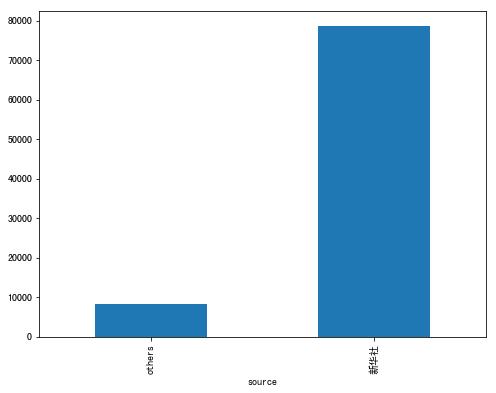

In [86]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
fig = plt.figure(figsize=(8,6))
data.groupby('source').content.count().plot.bar(ylim=0)
plt.show()

In [87]:
data = data.fillna('')
content = data['content'].tolist()
content[:3]

['此外，自本周（6月12日）起，除小米手机6等15款机型外，其余机型已暂停更新发布（含开发版/体验版内测，稳定版暂不受影响），以确保工程师可以集中全部精力进行系统优化工作。有人猜测这也是将精力主要用到MIUI 9的研发之中。\r\nMIUI 8去年5月发布，距今已有一年有余，也是时候更新换代了。\r\n当然，关于MIUI 9的确切信息，我们还是等待官方消息。\r\n',
 '骁龙835作为唯一通过Windows 10桌面平台认证的ARM处理器，高通强调，不会因为只考虑性能而去屏蔽掉小核心。相反，他们正联手微软，找到一种适合桌面平台的、兼顾性能和功耗的完美方案。\r\n报道称，微软已经拿到了一些新的源码，以便Windows 10更好地理解big.little架构。\r\n资料显示，骁龙835作为一款集成了CPU、GPU、基带、蓝牙/Wi-Fi的SoC，比传统的Wintel方案可以节省至少30%的PCB空间。\r\n按计划，今年Q4，华硕、惠普、联想将首发骁龙835 Win10电脑，预计均是二合一形态的产品。\r\n当然，高通骁龙只是个开始，未来也许还能见到三星Exynos、联发科、华为麒麟、小米澎湃等进入Windows 10桌面平台。\r\n',
 '此前的一加3T搭载的是3400mAh电池，DashCharge快充规格为5V/4A。\r\n至于电池缩水，可能与刘作虎所说，一加手机5要做市面最轻薄大屏旗舰的设定有关。\r\n按照目前掌握的资料，一加手机5拥有5.5寸1080P三星AMOLED显示屏、6G/8GB RAM，64GB/128GB ROM，双1600万摄像头，备货量“惊喜”。\r\n根据京东泄露的信息，一加5起售价是xx99元，应该是在2799/2899/2999中的某个。\r\n']

In [89]:
def token(string):
    return re.findall(r'[\d|\w]+',string)

# 定义读取停用词文件的函数
def read_stopwords(path):
    lines = set()
    with open(path, mode='r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            lines.add(line)
    return lines
# 移除停用词
STOP_WORDS = read_stopwords("./datasets/stop_words.txt")

# 对句子进行分词
def seg_sentence(sentence):
    sentence_seged = jieba.cut(sentence.strip())
    outstr = ''
    for word in sentence_seged:
        if word not in STOP_WORDS:
            if word != '\t':
                outstr += word
                outstr += " "
    return outstr
def save_sentence(lines, sentence_path):
    with open(sentence_path, 'w', encoding='utf-8') as f:
        for line in lines:
            f.write('%s\n' % line.strip())
    print('save sentence:%s' % sentence_path)

In [88]:
sentence_path = './datasets/newstext.txt'

news_content = [token(n) for n in content]
news_content = [' '.join(n) for n in news_content]

sentences = [seg_sentence(sen) for sen in news_content]
save_sentence(sentences,sentence_path)

save sentence:./datasets/newstext.txt


In [90]:
sentences[:4]

['  本周   6 月 12 日     小米 手机 6 15 款 机型 外   机型 已 暂停 更新 发布   含 开发 版   体验版 内测   稳定版 暂不受 影响   确保 工程师 精力 系统优化 工作   有人 猜测 精力 用到 MIUI   9 研发 之中   MIUI   8 去年 5 月 发布   距今已有 一年 有余   更新换代     MIUI   9 确切 信息   等待 官方消息 ',
 '骁龙 835 唯一 Windows   10 桌面 平台 认证 ARM 处理器   高通   只 性能 去 屏蔽掉 小 核心     正 联手 微软   找到 一种 适合 桌面 平台   兼顾 性能 功耗 完美 方案   报道 称   微软 拿到 新 源码   Windows   10 更好 理解 big   架构   资料 显示   骁龙 835 一款 集成 CPU   GPU   基带   蓝牙   Wi   Fi SoC   传统 Wintel 方案 节省 至少 30   PCB 空间   按计划   Q4   华硕   惠普   联想 首发 骁龙 835   Win10 电脑   预计 均 二合一 形态 产品     高通 骁龙   未来 也许 见到 三星 Exynos   联发科   华为 麒麟   小米 澎湃 Windows   10 桌面 平台 ',
 '此前 一加 3T 搭载 3400mAh 电池   DashCharge 快充 规格 5V   4A   电池 缩水   刘作 虎 所说   一加 手机 5 做 市面 最 轻薄 大屏 旗舰 设定   资料   一加 手机 5 拥有 5   5 寸 1080P 三星 AMOLED 显示屏   6G   8GB   RAM   64GB   128GB   ROM   双 1600 万 摄像头   备货 量   惊喜   京东 泄露 信息   一加 5 售价 xx99 元   2799   2899   2999 中 ',
 '这是 6 月 18 日 葡萄牙 中部 大 佩德罗 冈 地区 拍摄 森林 大火 烧毁 汽车   新华社 记者 张立 云摄 ']

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.model_selection import train_test_split

# category_id： 新华社:1 其他others：0
x_train, x_test, y_train, y_test = train_test_split(sentences, data.category_id.values,
                                                  random_state=1, 
                                                  test_size=0.1, shuffle=True)


# 将语料转化为词袋向量，根据词袋向量统计TF-IDF
vectorizer = CountVectorizer(max_features=5000)
tf_idf_transformer = TfidfTransformer()
tf_idf = tf_idf_transformer.fit_transform(vectorizer.fit_transform(x_train))
x_train_weight = tf_idf.toarray()  # 训练集TF-IDF权重矩阵
tf_idf = tf_idf_transformer.transform(vectorizer.transform(x_test))
x_test_weight = tf_idf.toarray()  # 测试集TF-IDF权重矩阵

In [93]:
# 将数据转化为DMatrix类型
import xgboost as xgb
dtrain = xgb.DMatrix(x_train_weight, label=y_train)
dtest = xgb.DMatrix(x_test_weight, label=y_test)

/Users/maytone/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/maytone/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


###### 2. Secondly,  pick a machine learning algorithm that you think is suitable for this task

In [94]:
'''
基于Scikit-learn接口的分类
xgb参数：
    silent [default=0]：取0时表示打印出运行时信息，取1时表示以缄默方式运行，不打印运行时信息。缺省值为0
    nthread：XGBoost运行时的线程数。缺省值是当前系统可以获得的最大线程数
    subsample [default=1]：用于训练模型的子样本占整个样本集合的比例。如果设置为0.5则意味着XGBoost将随机的从整个样本集合中随机的抽取出50%的子样本建立树模型，这能够防止过拟合。
取值范围为：(0,1]
    colsample_bytree [default=1]在建立树时对特征采样的比例。缺省值为1，取值范围：(0,1]
    n_estimatores:总共迭代的次数，即决策树的个数
'''
# 训练模型
model = xgb.XGBClassifier(max_depth=7, learning_rate=0.1, 
                          n_estimators=200, 
                          colsample_bytree=0.8,
                          subsample=0.8,
                          silent=True, 
                          nthread=10)
model.fit(x_train_weight, y_train)
y_predict = model.predict(x_test_weight)

[19:16:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [98]:
'''
验证模型结果:
新华社:1 
其他others：0

'''
label_all = [0, 1]
confusion_mat = metrics.confusion_matrix(y_test, y_predict)
df = pd.DataFrame(confusion_mat, columns=label_all)
df.index = label_all
print('准确率：', metrics.accuracy_score(y_test, y_predict))
print('confusion_matrix:\n', df)
print('分类报告:\n', metrics.classification_report(y_test, y_predict))

准确率： 0.9925338846772341
confusion_matrix:
      0     1
0  844    31
1   34  7797
分类报告:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       875
           1       1.00      1.00      1.00      7831

    accuracy                           0.99      8706
   macro avg       0.98      0.98      0.98      8706
weighted avg       0.99      0.99      0.99      8706



### Congratulations! You have completed all assignments in this week. The question below is optional. If you still have time, why don't try it out.

## Option:

#### Try differnt machine learning algorithms with different combinations of parameters in the practical part, and compare their performances (Better use some visualization techiniques).